<a href="https://colab.research.google.com/github/MasaAsami/commentary_mjca/blob/main/notebooks/simple_sample_mjca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn のスタイルとコンテキストを設定
sns.set_style("ticks")          # クリーンなスタイル
sns.set_context("paper")        # 論文用のコンテキスト設定


In [9]:
# データ生成プロセス
def generate_simple_data(N=2000, train_ratio=0.5, seed=1):
    np.random.seed(seed)
    # 特徴量 x ("強盗犯罪" フラグ)
    x = np.random.binomial(1, 0.1, N)  # 強盗: 1, その他: 0
    x2 = np.random.normal(0, 1, N) # np.random.binomial(1, 0.5, N)

    # 傾向スコア π_0(a=1 | x="強盗")
    pi_0 = 0.7 * x + 0.25 * (1 - x)

    # 処置 a (少年院送致)
    a = np.random.binomial(1, pi_0, N)

    # ノイズ ε
    epsilon = np.random.normal(0, 1, N)

    # アウトカム r
    z = - 1 * a + 0.5 * x - 0.5 * x2+ epsilon
    r = 1 / (1 + np.exp(-z))  # シグモイド関数

    # 観測されたアウトカム r を 0/1 の離散値に変換
    r_binary = (r > 0.5).astype(int)

    # データフレームの作成
    data = pd.DataFrame({'x': x, 'x2' : x2,'a': a, 'r': r_binary})

    # データを分割
    train_size = int(N * train_ratio)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    return train_data, test_data


Optimization terminated successfully.
         Current function value: 0.631757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584121
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      r   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Mon, 30 Dec 2024   Pseudo R-squ.:                 0.07507
Time:                        04:24:11   Log-Likelihood:                -631.76
converged:                       True   LL-Null:                       -683.03
Covariance Type:            nonrobust   LLR p-value:                 5.396e-23
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const 

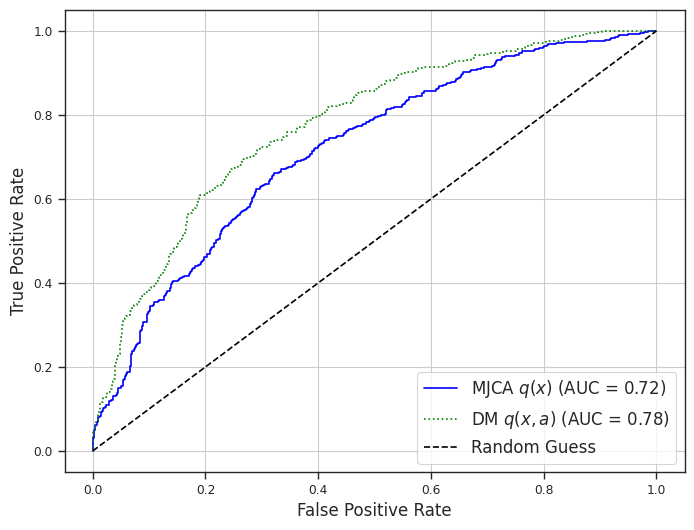

In [10]:
# データ生成
train_data, test_data = generate_simple_data(seed=2025)

# MJCAモデル (E[r | x]) を学習 (statsmodels を使用)
X_train = sm.add_constant(train_data[['x', 'x2']])  # 定数項を追加
y_train = train_data['r']
mjca_model = sm.Logit(y_train, X_train).fit()
q_model = sm.Logit(y_train, sm.add_constant(train_data[['x', 'x2', 'a']])).fit()

# モデルの要約を表示
print(mjca_model.summary())
print(q_model.summary())

# テストデータの予測
X_test = sm.add_constant(test_data[['x', 'x2']])
test_data['r_pred'] = mjca_model.predict(X_test)

X_test_q = sm.add_constant(test_data[['x', 'x2', 'a']])
test_data['r_pred_q'] = q_model.predict(X_test_q)

# ROC曲線とAUCスコア
fpr, tpr, thresholds = roc_curve(test_data['r'], test_data['r_pred'])
auc_score = roc_auc_score(test_data['r'], test_data['r_pred'])

fpr_q, tpr_q, thresholds_q = roc_curve(test_data['r'], test_data['r_pred_q'])
auc_score_q = roc_auc_score(test_data['r'], test_data['r_pred_q'])

# ROC曲線をプロット
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'MJCA $q(x)$ (AUC = {auc_score:.2f})')
plt.plot(fpr_q, tpr_q, ':',color='green',label=f'DM $q(x, a)$ (AUC = {auc_score_q:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.savefig('simple_sim_plots.png', dpi=300)
plt.show()